# Ulwetel Churn Prediction

Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE 
from collections import Counter
pd.set_option("display.max.columns",None)

Reading csv file

In [2]:
df = pd.read_csv('churn_prediction_dataset.csv')

In [3]:
df.head()

,customer_id,ownership,activation_plan_code,mnp_flag,calls_incoming_cnt,calls_outgoing_cnt,calls_incoming_duration,calls_outgoing_duration,total_call_count,total_sum_duration,tot_usage_mb,upload_usage_mb,download_usage_mb,days_since_latch,cnt_open_qrc,avg_days_to_close,cnt_call_drops,pcnt_dropped_calls,rsrp_voice_pcnt_poor_duration,rsrp_data_pcnt_poor_duration,mean_cqi_voice_pcnt_poor_duration,sinr_voice_pcnt_poor_duration,sinr_data_pcnt_poor_duration,age_on_network,cnt_connections,current_plan_code,cnt_recharges_made,total_payment_made,cnt_main_plans_taken,total_main_plans_mrp,cnt_addon_plans_taken,total_addon_plans_mrp,cnt_rchg_offline,cnt_rchg_online,cnt_rchg_on_or_before_expiry,cnt_rchg_after_expiry,current_active_plan_mrp,current_active_plan_validity,last_cycle_plan_mrp,last_cycle_plan_validity,avg_days_bw_rchg_and_expiry,stddev_days_bw_rchg_and_expiry,price_per_day,gb_per_day_quota,pcnt_quota_used,device_avg_asp,recharge_delay,churn
0,10000,individual,4,0,31.0,333.0,31.980873,548.719449,364.0,580.700321,3163.351573,218.669764,2944.681809,14,5,12.0,15.850024,4.354402,17.953422,19.367968,91.668110,23.558871,26.801912,1081,6,4,118,11616.546516,53,5217.601401,65,6398.945115,55,63,55.0,63.0,300,90,2999,700,-1.113238,2.801930,3.333333,1.5,6.864912,10K_to_20K,-3.221785,0
1,10001,individual,6,0,8.0,42.0,9.577651,43.988952,50.0,53.566603,3672.746526,1406.966020,2265.780505,2,5,8.0,2.041106,4.082213,50.417468,56.131160,41.213461,13.093980,15.351267,1243,6,9,134,12063.660870,99,8912.704672,35,3150.956197,63,71,108.0,26.0,999,180,2999,700,-2.032090,1.600223,5.550000,3.0,3.985185,10K_to_20K,-4.916200,0
2,10002,individual,8,1,13.0,0.0,15.368591,0.000000,13.0,15.368591,4712.106937,1218.473756,3493.633182,1,3,13.0,0.527123,4.054789,69.855933,84.210546,58.969216,98.521221,99.934127,595,3,4,68,53.104257,47,36.704413,21,16.399844,30,38,57.0,11.0,128,28,500,120,-2.350133,0.782016,4.571429,1.0,15.338890,20K_to_30K,4.455835,0
3,10003,individual,7,0,20.0,38.0,21.091508,52.044282,58.0,73.135790,11356.222392,1327.000054,10029.222338,2,7,6.0,2.366328,4.079876,37.472380,45.964767,69.585481,22.996520,27.170476,732,7,4,82,11613.017620,16,2265.954658,66,9347.062962,37,45,55.0,27.0,2999,700,500,120,2.366904,1.255292,4.284286,4.0,9.241717,less_10K,0.180850,0
4,10004,individual,3,1,22.0,29.0,25.592874,41.290402,51.0,66.883276,11302.446568,84.280664,11218.165904,2,7,8.0,1.307365,2.563461,65.076399,65.635028,76.365055,88.513859,96.226030,398,7,10,48,385.772823,18,144.664809,30,241.108015,20,28,11.0,37.0,1500,365,999,180,2.121814,3.132883,4.109589,3.0,12.263939,10K_to_20K,4.690059,0


Feature Engineering<br>

Columns to be dropped:<br>
1. total_call_count: This is a redundant column as it is an addition of incoming call count and outgoing call count. Total calls is not important, individual calls are important, as some customers might be using the sim as a secondary sim just for emergencies or bank otps, and are more likely to churn.<br>
2. total_sum_duration: This is a redundant column as it is an addition of incoming call duration and outgoing call duration. Total calls duration is not important, individual calls durations are important, as some customers might be using the sim as a secondary sim just for emergencies or bank otps, and are more likely to churn.<br>
3. tot_usage_mb: This is a redundant column as it is an addition of incoming usage mb and outgoing usage mb. Total usage mb is not important, individual calls durations are important, as some customers might be using the sim as a secondary sim just for emergencies or bank otps, and are more likely to churn.<br>
4. cnt_call_drops: This is a redundant column as there is another column pcnt_dropped_calls, which is more important as it shows a percentage of total calls dropped rather than an absolute count.<br>
5. stddev_days_bw_rchg_and_expiry: Dropping this column as average days between recharge and expiry is available.<br>
6. price_per_day: This column does not seem to add value since we have the mrp and validity of the plans available.<br>

In [4]:
df = df.drop(['total_call_count', 'total_sum_duration', 'tot_usage_mb', 'cnt_call_drops', 'stddev_days_bw_rchg_and_expiry', 'price_per_day'], axis=1)

In [5]:
df.head()

,customer_id,ownership,activation_plan_code,mnp_flag,calls_incoming_cnt,calls_outgoing_cnt,calls_incoming_duration,calls_outgoing_duration,upload_usage_mb,download_usage_mb,days_since_latch,cnt_open_qrc,avg_days_to_close,pcnt_dropped_calls,rsrp_voice_pcnt_poor_duration,rsrp_data_pcnt_poor_duration,mean_cqi_voice_pcnt_poor_duration,sinr_voice_pcnt_poor_duration,sinr_data_pcnt_poor_duration,age_on_network,cnt_connections,current_plan_code,cnt_recharges_made,total_payment_made,cnt_main_plans_taken,total_main_plans_mrp,cnt_addon_plans_taken,total_addon_plans_mrp,cnt_rchg_offline,cnt_rchg_online,cnt_rchg_on_or_before_expiry,cnt_rchg_after_expiry,current_active_plan_mrp,current_active_plan_validity,last_cycle_plan_mrp,last_cycle_plan_validity,avg_days_bw_rchg_and_expiry,gb_per_day_quota,pcnt_quota_used,device_avg_asp,recharge_delay,churn
0,10000,individual,4,0,31.0,333.0,31.980873,548.719449,218.669764,2944.681809,14,5,12.0,4.354402,17.953422,19.367968,91.668110,23.558871,26.801912,1081,6,4,118,11616.546516,53,5217.601401,65,6398.945115,55,63,55.0,63.0,300,90,2999,700,-1.113238,1.5,6.864912,10K_to_20K,-3.221785,0
1,10001,individual,6,0,8.0,42.0,9.577651,43.988952,1406.966020,2265.780505,2,5,8.0,4.082213,50.417468,56.131160,41.213461,13.093980,15.351267,1243,6,9,134,12063.660870,99,8912.704672,35,3150.956197,63,71,108.0,26.0,999,180,2999,700,-2.032090,3.0,3.985185,10K_to_20K,-4.916200,0
2,10002,individual,8,1,13.0,0.0,15.368591,0.000000,1218.473756,3493.633182,1,3,13.0,4.054789,69.855933,84.210546,58.969216,98.521221,99.934127,595,3,4,68,53.104257,47,36.704413,21,16.399844,30,38,57.0,11.0,128,28,500,120,-2.350133,1.0,15.338890,20K_to_30K,4.455835,0
3,10003,individual,7,0,20.0,38.0,21.091508,52.044282,1327.000054,10029.222338,2,7,6.0,4.079876,37.472380,45.964767,69.585481,22.996520,27.170476,732,7,4,82,11613.017620,16,2265.954658,66,9347.062962,37,45,55.0,27.0,2999,700,500,120,2.366904,4.0,9.241717,less_10K,0.180850,0
4,10004,individual,3,1,22.0,29.0,25.592874,41.290402,84.280664,11218.165904,2,7,8.0,2.563461,65.076399,65.635028,76.365055,88.513859,96.226030,398,7,10,48,385.772823,18,144.664809,30,241.108015,20,28,11.0,37.0,1500,365,999,180,2.121814,3.0,12.263939,10K_to_20K,4.690059,0


There are 26 null values in avg_days_to_close

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        1000 non-null   int64  
 1   ownership                          1000 non-null   object 
 2   activation_plan_code               1000 non-null   int64  
 3   mnp_flag                           1000 non-null   int64  
 4   calls_incoming_cnt                 1000 non-null   float64
 5   calls_outgoing_cnt                 1000 non-null   float64
 6   calls_incoming_duration            1000 non-null   float64
 7   calls_outgoing_duration            1000 non-null   float64
 8   upload_usage_mb                    1000 non-null   float64
 9   download_usage_mb                  1000 non-null   float64
 10  days_since_latch                   1000 non-null   int64  
 11  cnt_open_qrc                       1000 non-null   int64 

In [7]:
df['avg_days_to_close'].describe()

count    974.000000
mean       8.944559
std        3.129445
min        4.000000
25%        6.000000
50%        9.000000
75%       12.000000
max       14.000000
Name: avg_days_to_close, dtype: float64

In [8]:
df.loc[df['avg_days_to_close'].isnull() == True]

,customer_id,ownership,activation_plan_code,mnp_flag,calls_incoming_cnt,calls_outgoing_cnt,calls_incoming_duration,calls_outgoing_duration,upload_usage_mb,download_usage_mb,days_since_latch,cnt_open_qrc,avg_days_to_close,pcnt_dropped_calls,rsrp_voice_pcnt_poor_duration,rsrp_data_pcnt_poor_duration,mean_cqi_voice_pcnt_poor_duration,sinr_voice_pcnt_poor_duration,sinr_data_pcnt_poor_duration,age_on_network,cnt_connections,current_plan_code,cnt_recharges_made,total_payment_made,cnt_main_plans_taken,total_main_plans_mrp,cnt_addon_plans_taken,total_addon_plans_mrp,cnt_rchg_offline,cnt_rchg_online,cnt_rchg_on_or_before_expiry,cnt_rchg_after_expiry,current_active_plan_mrp,current_active_plan_validity,last_cycle_plan_mrp,last_cycle_plan_validity,avg_days_bw_rchg_and_expiry,gb_per_day_quota,pcnt_quota_used,device_avg_asp,recharge_delay,churn
15,10015,individual,8,0,72.0,40.0,108.450299,69.872379,1881.627084,6455.829663,4,0,NaN,4.833248,0.428933,0.486242,84.603084,67.270158,67.395951,340,2,7,44,1353.342542,18,553.640131,26,799.702411,18,26,26.0,18.0,500,120,99,15,-5.162075,2.0,13.570079,less_10K,-3.206136,0
42,10042,individual,7,0,34.0,42.0,34.211552,72.437373,1197.239418,9183.985844,3,0,NaN,1.051966,57.685947,61.947030,37.228239,16.002023,16.107098,1110,1,8,120,35368.800357,61,17979.140181,59,17389.660176,56,64,90.0,30.0,128,28,2999,700,10.563870,1.0,33.793051,10K_to_20K,8.851919,1
60,10060,individual,8,0,64.0,110.0,124.837317,184.601143,1805.870438,10240.759043,7,0,NaN,1.425152,33.099733,38.718581,7.068965,0.879272,0.951052,619,8,6,72,13285.498077,28,5166.582585,44,8118.915491,32,40,40.0,32.0,999,180,1500,365,-3.408692,3.0,13.071430,20K_to_30K,-15.108207,0
68,10068,individual,2,0,238.0,56.0,463.188520,110.660969,1305.088958,17675.458827,11,0,NaN,1.336680,54.464997,58.229032,50.858059,12.503334,15.259545,453,3,10,54,5756.353724,16,1705.586289,38,4050.767435,23,31,18.0,36.0,500,120,500,120,-0.396398,2.0,30.892819,30K_to_50K,-6.543968,0
232,10232,individual,9,0,75.0,290.0,97.124685,302.281685,3408.620629,19178.197315,14,0,NaN,1.242263,22.774654,28.012593,29.905448,82.691227,85.537814,694,6,9,78,11303.925703,62,8985.171713,16,2318.753990,35,43,70.0,8.0,500,120,999,180,-0.728904,2.0,36.762399,less_10K,1.517710,0
320,10320,individual,3,0,66.0,19.0,90.235387,34.789102,1008.667896,1389.257437,3,0,NaN,3.059115,61.090929,62.118252,4.528771,5.013195,6.074574,1170,8,1,126,585.350332,45,209.053690,81,376.296642,59,67,29.0,97.0,99,15,2999,700,-9.638162,0.5,15.611493,10K_to_20K,-19.032666,0
335,10335,individual,10,0,179.0,5.0,286.280766,6.185478,681.268587,2515.337044,7,0,NaN,2.662363,57.670271,68.166531,15.480304,30.789000,35.859967,523,8,7,62,7355.049988,32,3796.154833,30,3558.895156,27,35,1.0,61.0,2999,700,128,28,2.006593,4.0,2.601404,20K_to_30K,-5.070599,0
339,10339,individual,8,0,71.0,27.0,91.854772,46.862854,623.791744,15013.619950,4,0,NaN,2.256006,49.086414,59.087127,75.087757,85.714015,89.083498,322,2,10,42,1536.518115,29,1060.929175,13,475.588940,17,25,40.0,2.0,99,15,999,180,-0.841057,0.5,101.806066,less_10K,-5.375697,0
358,10358,individual,4,0,45.0,77.0,87.978683,134.658966,34.938082,32302.567511,5,0,NaN,3.260872,22.869685,23.403337,44.949735,41.299184,44.049904,376,4,3,46,2798.316763,29,1764.156220,17,1034.160543,19,27,2.0,44.0,128,28,128,28,0.205498,1.0,105.265318,less_10K,-15.243323,0
359,10359,corporate,9,0,78.0,100.0,145.419123,121.731414,3175.430303,3066.073495,7,0,NaN,4.309914,44.945547,45.773781,66.699003,65.844134,67.230115,460,8,10,56,5533.349262,29,2865.484439,27,2667.864823,24,32,4.0,52.0,99,15,128,28,-9.492640,0.5,40.634790,30K_to_50K,6.201665,0


We will impute:<br>
1. 26 null values avg days to close with the mode<br>
2. Individual with 1, Corporate with 0
3. Device avg price with 1,2,3,4,5

In [9]:
df['avg_days_to_close'] = df['avg_days_to_close'].fillna(df['avg_days_to_close'].mode()[0])
df = df.replace('individual',1)
df = df.replace('corporate',0)
df = df.replace('less_10K',1)
df = df.replace('10K_to_20K',2)
df = df.replace('20K_to_30K',3)
df = df.replace('30K_to_50K',4)
df = df.replace('50K_above',5)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        1000 non-null   int64  
 1   ownership                          1000 non-null   int64  
 2   activation_plan_code               1000 non-null   int64  
 3   mnp_flag                           1000 non-null   int64  
 4   calls_incoming_cnt                 1000 non-null   float64
 5   calls_outgoing_cnt                 1000 non-null   float64
 6   calls_incoming_duration            1000 non-null   float64
 7   calls_outgoing_duration            1000 non-null   float64
 8   upload_usage_mb                    1000 non-null   float64
 9   download_usage_mb                  1000 non-null   float64
 10  days_since_latch                   1000 non-null   int64  
 11  cnt_open_qrc                       1000 non-null   int64 

List of Numerical features

In [11]:
numerical = []
for i in df.columns:
    if(df[i].dtype!='O'):
        numerical.append(i)
numerical

['customer_id',
 'ownership',
 'activation_plan_code',
 'mnp_flag',
 'calls_incoming_cnt',
 'calls_outgoing_cnt',
 'calls_incoming_duration',
 'calls_outgoing_duration',
 'upload_usage_mb',
 'download_usage_mb',
 'days_since_latch',
 'cnt_open_qrc',
 'avg_days_to_close',
 'pcnt_dropped_calls',
 'rsrp_voice_pcnt_poor_duration',
 'rsrp_data_pcnt_poor_duration',
 'mean_cqi_voice_pcnt_poor_duration',
 'sinr_voice_pcnt_poor_duration',
 'sinr_data_pcnt_poor_duration',
 'age_on_network',
 'cnt_connections',
 'current_plan_code',
 'cnt_recharges_made',
 'total_payment_made',
 'cnt_main_plans_taken',
 'total_main_plans_mrp',
 'cnt_addon_plans_taken',
 'total_addon_plans_mrp',
 'cnt_rchg_offline',
 'cnt_rchg_online',
 'cnt_rchg_on_or_before_expiry',
 'cnt_rchg_after_expiry',
 'current_active_plan_mrp',
 'current_active_plan_validity',
 'last_cycle_plan_mrp',
 'last_cycle_plan_validity',
 'avg_days_bw_rchg_and_expiry',
 'gb_per_day_quota',
 'pcnt_quota_used',
 'device_avg_asp',
 'recharge_delay',

List of categorical features. No categorical values

In [12]:
categorical = []
for i in df.columns:
    if(df[i].dtype=='O'):
        categorical.append(i)
categorical

[]

In [13]:
df.describe()

,customer_id,ownership,activation_plan_code,mnp_flag,calls_incoming_cnt,calls_outgoing_cnt,calls_incoming_duration,calls_outgoing_duration,upload_usage_mb,download_usage_mb,days_since_latch,cnt_open_qrc,avg_days_to_close,pcnt_dropped_calls,rsrp_voice_pcnt_poor_duration,rsrp_data_pcnt_poor_duration,mean_cqi_voice_pcnt_poor_duration,sinr_voice_pcnt_poor_duration,sinr_data_pcnt_poor_duration,age_on_network,cnt_connections,current_plan_code,cnt_recharges_made,total_payment_made,cnt_main_plans_taken,total_main_plans_mrp,cnt_addon_plans_taken,total_addon_plans_mrp,cnt_rchg_offline,cnt_rchg_online,cnt_rchg_on_or_before_expiry,cnt_rchg_after_expiry,current_active_plan_mrp,current_active_plan_validity,last_cycle_plan_mrp,last_cycle_plan_validity,avg_days_bw_rchg_and_expiry,gb_per_day_quota,pcnt_quota_used,device_avg_asp,recharge_delay,churn
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1.000000e+03,1000.00000
mean,10499.500000,0.83700,5.547000,0.095000,59.098000,60.789000,89.315690,91.910980,1492.948029,10001.526572,4.58600,4.368000,8.946000,3.475282,43.659219,48.612335,52.362551,45.376558,50.405709,583.031000,4.433000,5.551000,67.460000,8752.140477,33.913000,4316.693361,33.54700,4435.447117,29.730000,37.730000,34.29200,33.168000,873.871000,200.260000,950.667000,218.992000,-0.043774,2.067000,28.606507,3.01400,4.920508e-15,0.25600
std,288.819436,0.36955,2.871243,0.293362,59.655588,59.257032,93.959748,92.734500,1507.621368,9349.571920,3.20919,2.467522,3.088466,1.459016,26.126632,28.762165,28.994246,26.823062,29.542503,253.041423,2.295818,2.913398,25.292452,10133.829641,17.651317,5228.805124,17.92532,5824.604116,12.646226,12.646226,24.49336,24.202139,927.073983,217.375676,977.437282,229.023977,2.881490,1.153621,37.037698,1.40847,9.698316e+00,0.43664
min,10000.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.044787,31.920839,0.00000,0.000000,4.000000,1.003499,0.096685,0.112637,0.126315,0.024001,0.027592,19.000000,1.000000,1.000000,12.000000,4.090623,6.000000,0.981749,4.00000,3.108873,2.000000,10.000000,0.00000,0.000000,99.000000,15.000000,99.000000,15.000000,-19.453356,0.500000,0.070596,1.00000,-3.798367e+01,0.00000
25%,10249.750000,1.00000,3.000000,0.000000,19.000000,19.000000,26.809249,28.211860,423.033975,3040.574614,2.00000,3.000000,6.000000,2.362096,20.904805,23.997739,27.549738,20.720608,23.813690,402.750000,2.000000,3.000000,50.000000,2194.770230,21.000000,1016.694664,21.00000,997.747217,21.000000,29.000000,15.00000,14.000000,128.000000,28.000000,128.000000,28.000000,-1.421545,1.000000,7.314737,2.00000,-5.583596e+00,0.00000
50%,10499.500000,1.00000,5.000000,0.000000,40.000000,42.000000,59.200418,65.136142,1023.183572,7446.475160,4.00000,4.000000,9.000000,3.371796,42.996338,47.744208,52.984901,45.198208,50.407603,516.000000,4.000000,6.000000,60.000000,5457.577670,30.000000,2601.461945,30.00000,2458.538713,26.000000,34.000000,31.00000,30.000000,500.000000,120.000000,500.000000,120.000000,-0.004673,2.000000,15.631628,3.00000,1.001490e-01,0.00000
75%,10749.250000,1.00000,8.000000,0.000000,79.000000,85.000000,116.496060,127.278434,2002.049789,14179.891511,6.00000,6.000000,12.000000,4.427437,65.202303,72.994446,77.493763,67.551866,76.665621,700.500000,6.000000,8.000000,80.000000,11613.899844,42.000000,5700.731662,41.00000,5507.521104,36.000000,44.000000,47.00000,46.250000,1500.000000,365.000000,1500.000000,365.000000,1.375305,3.000000,34.260930,4.00000,5.339966e+00,1.00000
max,10999.000000,1.00000,10.000000,1.000000,531.000000,427.000000,957.042270,643.949805,10505.096786,54431.207592,22.00

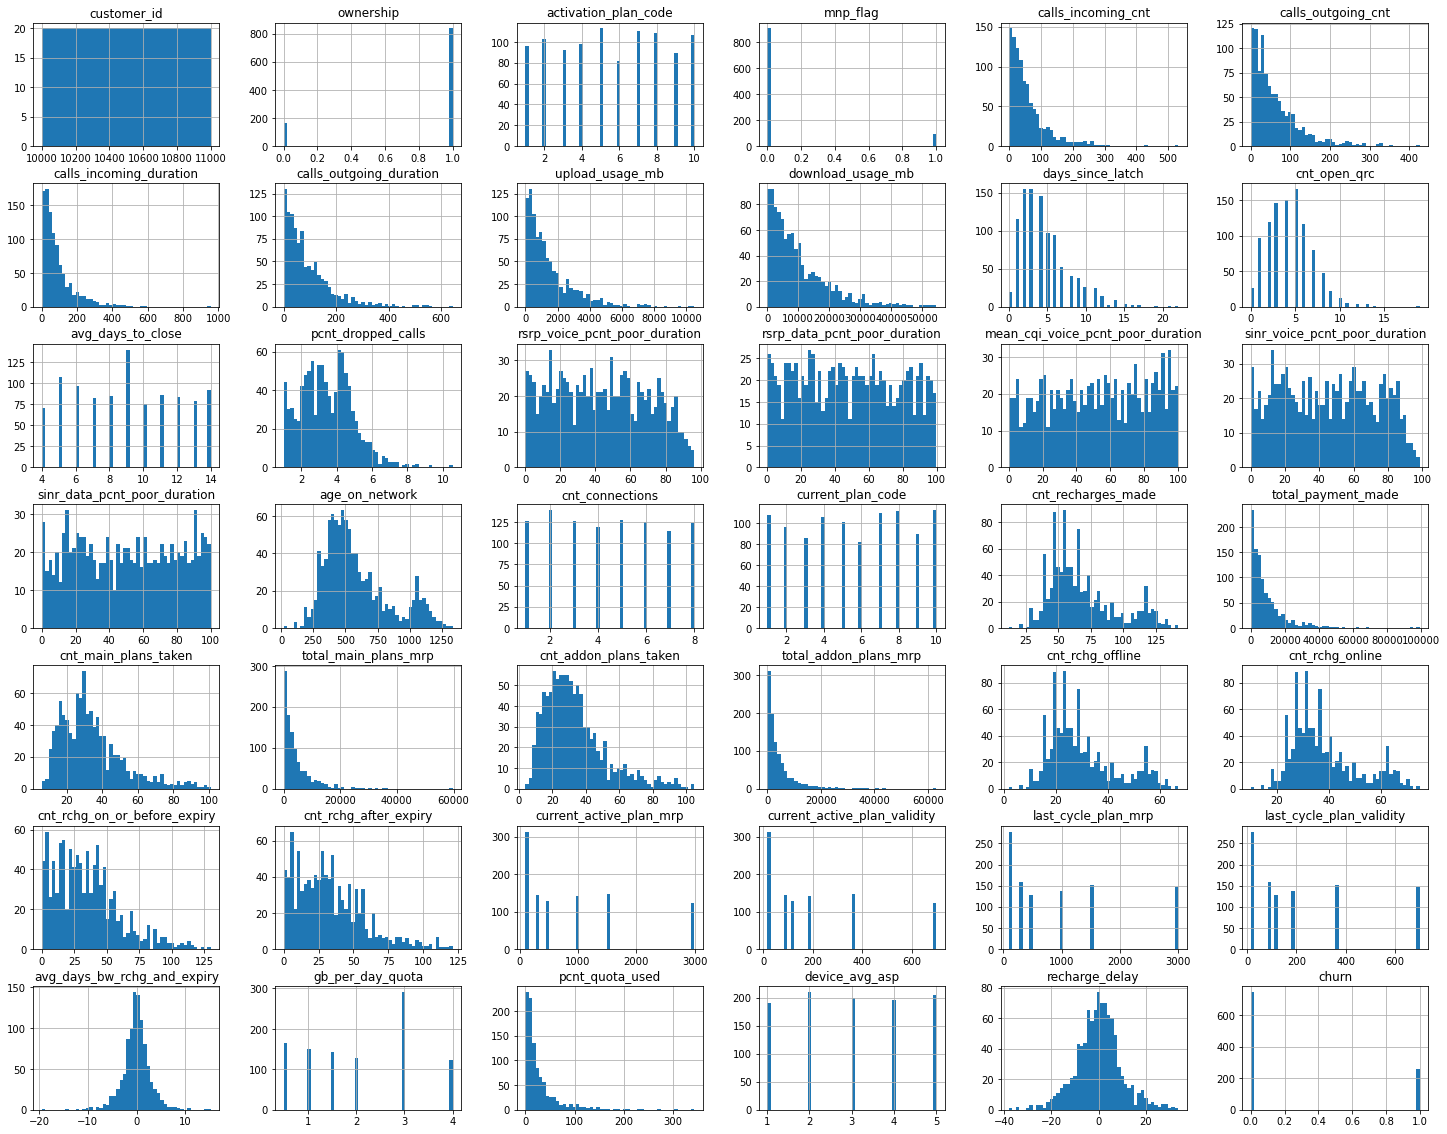

In [14]:
%matplotlib inline
df.hist(bins=50, figsize=(25,20))
plt.savefig("plots")
plt.show()

There is a 25.6% (1) to  74.4% (0) churn ratio

In [15]:
print('Number of churn = 1:', df['churn'].value_counts()[1])
print('Number of churn = 0:', df['churn'].value_counts()[0])

Number of churn = 1: 256
Number of churn = 0: 744


<AxesSubplot:>

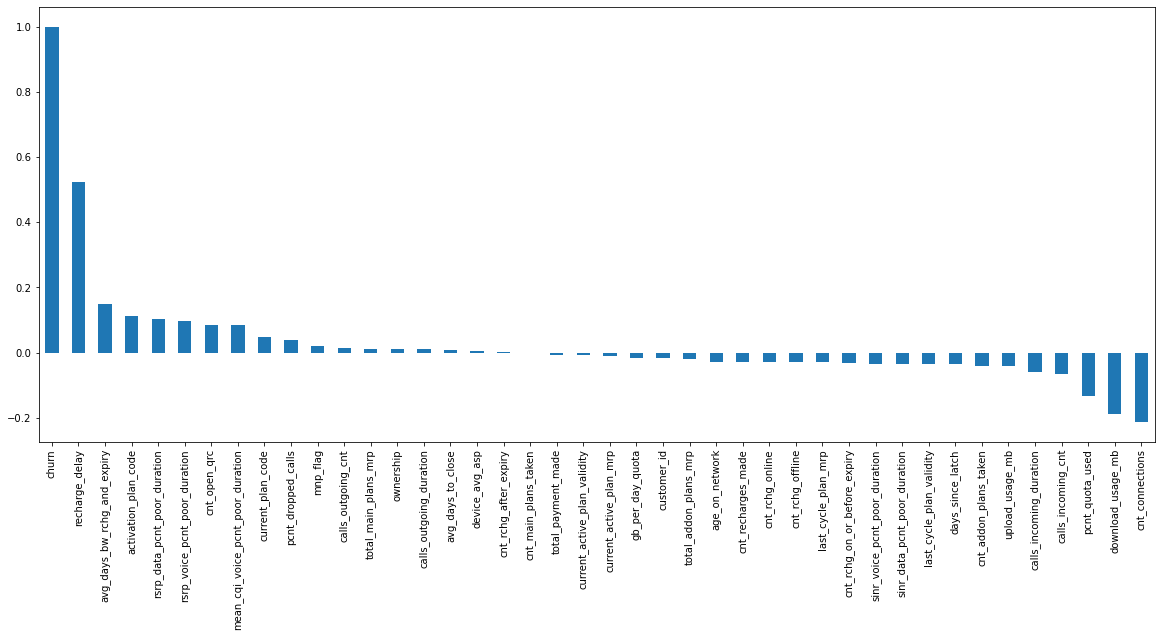

In [16]:
plt.figure(figsize=(20,8))
df.corr()['churn'].sort_values(ascending = False).plot(kind='bar')

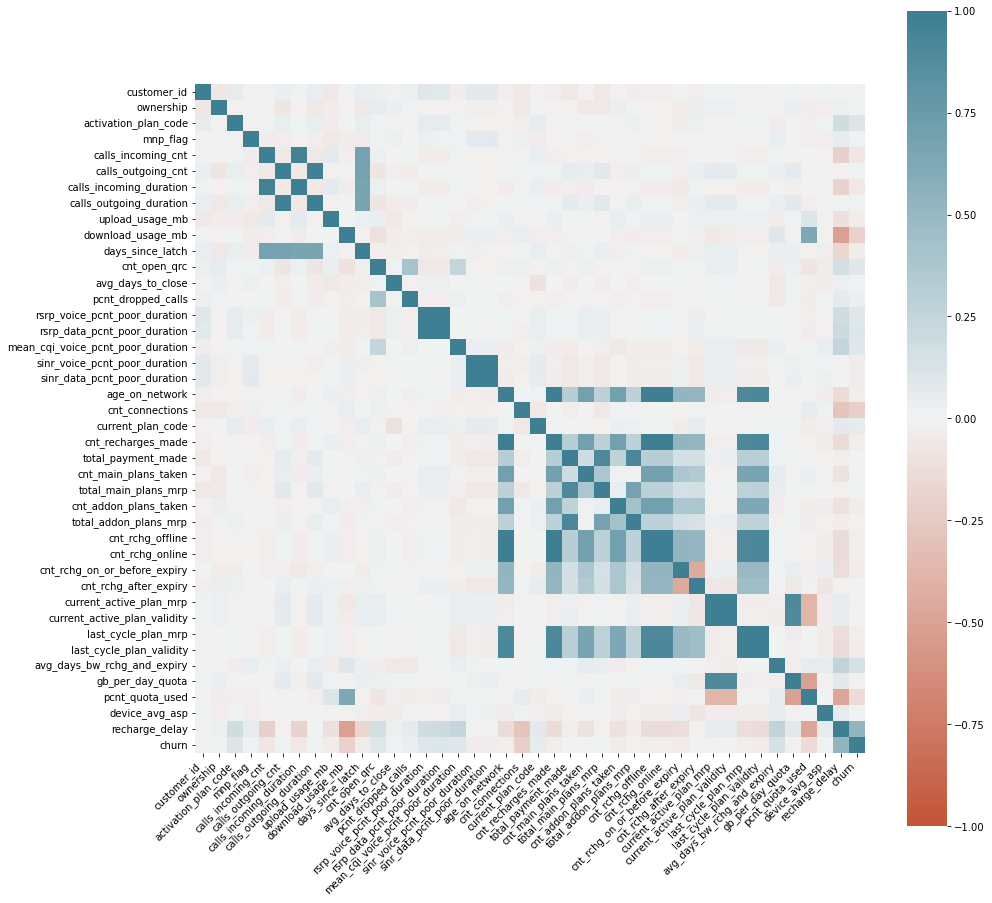

In [17]:
fig = plt.figure(figsize=(15,15))
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Scaling features.

In [18]:
Scaler = MinMaxScaler()

In [19]:
df_arr=Scaler.fit_transform(df[numerical])

In [20]:
df=pd.DataFrame(df_arr,columns=numerical)

In [21]:
df.head()

,customer_id,ownership,activation_plan_code,mnp_flag,calls_incoming_cnt,calls_outgoing_cnt,calls_incoming_duration,calls_outgoing_duration,upload_usage_mb,download_usage_mb,days_since_latch,cnt_open_qrc,avg_days_to_close,pcnt_dropped_calls,rsrp_voice_pcnt_poor_duration,rsrp_data_pcnt_poor_duration,mean_cqi_voice_pcnt_poor_duration,sinr_voice_pcnt_poor_duration,sinr_data_pcnt_poor_duration,age_on_network,cnt_connections,current_plan_code,cnt_recharges_made,total_payment_made,cnt_main_plans_taken,total_main_plans_mrp,cnt_addon_plans_taken,total_addon_plans_mrp,cnt_rchg_offline,cnt_rchg_online,cnt_rchg_on_or_before_expiry,cnt_rchg_after_expiry,current_active_plan_mrp,current_active_plan_validity,last_cycle_plan_mrp,last_cycle_plan_validity,avg_days_bw_rchg_and_expiry,gb_per_day_quota,pcnt_quota_used,device_avg_asp,recharge_delay,churn
0,0.000000,1.0,0.333333,0.0,0.058380,0.779859,0.033416,0.852115,0.020532,0.053544,0.636364,0.263158,0.8,0.350823,0.185199,0.193274,0.916610,0.238939,0.267875,0.806991,0.714286,0.333333,0.815385,0.116843,0.494737,0.087396,0.603960,0.101482,0.815385,0.815385,0.423077,0.520661,0.069310,0.109489,1.000000,1.000000,0.528377,0.285714,0.019811,0.25,0.485410,0.0
1,0.001001,1.0,0.555556,0.0,0.015066,0.098361,0.010008,0.068311,0.133681,0.041064,0.090909,0.263158,0.4,0.322326,0.521895,0.562281,0.411406,0.132694,0.153312,0.930091,0.714286,0.888889,0.938462,0.121341,0.978947,0.149302,0.306931,0.049946,0.938462,0.938462,0.830769,0.214876,0.310345,0.240876,1.000000,1.000000,0.501905,0.714286,0.011414,0.25,0.461749,0.0
2,0.002002,1.0,0.777778,1.0,0.024482,0.000000,0.016058,0.000000,0.115733,0.063635,0.045455,0.157895,0.9,0.319455,0.723498,0.844125,0.589195,1.000000,0.999557,0.437690,0.285714,0.333333,0.430769,0.000493,0.431579,0.000598,0.168317,0.000211,0.430769,0.430769,0.438462,0.090909,0.010000,0.018978,0.138276,0.153285,0.492742,0.142857,0.044519,0.50,0.592619,0.0
3,0.003003,1.0,0.666667,0.0,0.037665,0.088993,0.022038,0.080820,0.126066,0.183776,0.090909,0.368421,0.2,0.322082,0.387637,0.460237,0.695496,0.233230,0.271562,0.541793,0.857143,0.333333,0.538462,0.116807,0.105263,0.037946,0.613861,0.148259,0.538462,0.538462,0.423077,0.223140,1.000000,1.000000,0.138276,0.153285,0.628640,1.000000,0.026741,0.00,0.532924,0.0
4,0.004004,1.0,0.222222,1.0,0.041431,0.067916,0.026742,0.064121,0.007735,0.205632,0.090909,0.368421,0.4,0.163320,0.673928,0.657675,0.763380,0.898400,0.962458,0.287994,0.857143,1.000000,0.276923,0.003840,0.126316,0.002407,0.257426,0.003776,0.276923,0.276923,0.084615,0.305785,0.483103,0.510949,0.310345,0.240876,0.621579,0.714286,0.035553,0.25,0.595890,0.0


In [22]:
df.describe()

,customer_id,ownership,activation_plan_code,mnp_flag,calls_incoming_cnt,calls_outgoing_cnt,calls_incoming_duration,calls_outgoing_duration,upload_usage_mb,download_usage_mb,days_since_latch,cnt_open_qrc,avg_days_to_close,pcnt_dropped_calls,rsrp_voice_pcnt_poor_duration,rsrp_data_pcnt_poor_duration,mean_cqi_voice_pcnt_poor_duration,sinr_voice_pcnt_poor_duration,sinr_data_pcnt_poor_duration,age_on_network,cnt_connections,current_plan_code,cnt_recharges_made,total_payment_made,cnt_main_plans_taken,total_main_plans_mrp,cnt_addon_plans_taken,total_addon_plans_mrp,cnt_rchg_offline,cnt_rchg_online,cnt_rchg_on_or_before_expiry,cnt_rchg_after_expiry,current_active_plan_mrp,current_active_plan_validity,last_cycle_plan_mrp,last_cycle_plan_validity,avg_days_bw_rchg_and_expiry,gb_per_day_quota,pcnt_quota_used,device_avg_asp,recharge_delay,churn
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.500000,0.83700,0.505222,0.095000,0.111296,0.142363,0.093325,0.142730,0.141868,0.183267,0.208455,0.229895,0.494600,0.258784,0.451803,0.486811,0.523043,0.460445,0.504029,0.428595,0.490429,0.505667,0.426615,0.088021,0.293821,0.072303,0.292545,0.070327,0.426615,0.426615,0.263785,0.274116,0.267197,0.270453,0.293678,0.297799,0.559188,0.447714,0.083205,0.503500,0.530398,0.25600
std,0.289109,0.36955,0.319027,0.293362,0.112346,0.138775,0.098177,0.144009,0.143555,0.171869,0.145872,0.129870,0.308847,0.152752,0.270969,0.288698,0.290320,0.272323,0.295570,0.192281,0.327974,0.323711,0.194557,0.101965,0.185803,0.087600,0.177478,0.092418,0.194557,0.194557,0.188410,0.200018,0.319681,0.317337,0.337047,0.334342,0.083015,0.329606,0.107994,0.352118,0.135426,0.43664
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.250000,1.00000,0.222222,0.000000,0.035782,0.044496,0.028013,0.043811,0.039991,0.055307,0.090909,0.157895,0.200000,0.142238,0.215808,0.239744,0.274591,0.210124,0.237978,0.291603,0.142857,0.222222,0.292308,0.022042,0.157895,0.017017,0.168317,0.015782,0.292308,0.292308,0.115385,0.115702,0.010000,0.018978,0.010000,0.018978,0.519495,0.142857,0.021122,0.250000,0.452430,0.00000
50%,0.500000,1.00000,0.444444,0.000000,0.075330,0.098361,0.061858,0.101151,0.097137,0.136299,0.181818,0.210526,0.500000,0.247949,0.444928,0.478097,0.529274,0.458634,0.504048,0.377660,0.428571,0.555556,0.369231,0.054872,0.252632,0.043567,0.257426,0.038960,0.369231,0.369231,0.238462,0.247934,0.138276,0.153285,0.138276,0.153285,0.560315,0.428571,0.045373,0.500000,0.531797,0.00000
75%,0.750000,1.00000,0.777778,0.000000,0.148776,0.199063,0.121725,0.197653,0.190344,0.260076,0.272727,0.315789,0.800000,0.358470,0.675233,0.731544,0.774682,0.685581,0.766757,0.517857,0.714286,0.777778,0.523077,0.116816,0.378947,0.095490,0.366337,0.087338,0.523077,0.523077,0.361538,0.382231,0.483103,0.510949,0.483103,0.510949,0.600072,0.714286,0.099692,0.750000,0.604965,1.00000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00

Splitting dataset into train-test in the ratio 80%-20%

In [23]:
X=df.drop(["churn"],axis=1)
y = df["churn"]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20)

# Logistic Regression

In [25]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [26]:
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[145   3]
 [ 37  15]]
0.8
              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88       148
         1.0       0.83      0.29      0.43        52

    accuracy                           0.80       200
   macro avg       0.82      0.63      0.65       200
weighted avg       0.81      0.80      0.76       200



# XGBoost Classifier

In [27]:
Xclassifier=xgb.XGBClassifier()
Xclassifier.fit(X_train, y_train)
y_pred = Xclassifier.predict(X_test)

In [28]:
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[142   6]
 [ 17  35]]
0.885
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93       148
         1.0       0.85      0.67      0.75        52

    accuracy                           0.89       200
   macro avg       0.87      0.82      0.84       200
weighted avg       0.88      0.89      0.88       200



# Oversampling

Here, I am trying to oversample and see if there is any change in accuracy / F1-score

In [29]:
X_1 = df.drop(["churn"],axis=1)
y_1 = df["churn"]
SMOTE = SMOTE()
print('Original dataset shape %s' % Counter(y_1))
X_res, y_res = SMOTE.fit_resample(X_1,y_1)
print('After undersample dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 744, 1.0: 256})
After undersample dataset shape Counter({0.0: 744, 1.0: 744})


In [30]:
X_res

,customer_id,ownership,activation_plan_code,mnp_flag,calls_incoming_cnt,calls_outgoing_cnt,calls_incoming_duration,calls_outgoing_duration,upload_usage_mb,download_usage_mb,days_since_latch,cnt_open_qrc,avg_days_to_close,pcnt_dropped_calls,rsrp_voice_pcnt_poor_duration,rsrp_data_pcnt_poor_duration,mean_cqi_voice_pcnt_poor_duration,sinr_voice_pcnt_poor_duration,sinr_data_pcnt_poor_duration,age_on_network,cnt_connections,current_plan_code,cnt_recharges_made,total_payment_made,cnt_main_plans_taken,total_main_plans_mrp,cnt_addon_plans_taken,total_addon_plans_mrp,cnt_rchg_offline,cnt_rchg_online,cnt_rchg_on_or_before_expiry,cnt_rchg_after_expiry,current_active_plan_mrp,current_active_plan_validity,last_cycle_plan_mrp,last_cycle_plan_validity,avg_days_bw_rchg_and_expiry,gb_per_day_quota,pcnt_quota_used,device_avg_asp,recharge_delay
0,0.000000,1.0,0.333333,0.0,0.058380,0.779859,0.033416,0.852115,0.020532,0.053544,0.636364,0.263158,0.800000,0.350823,0.185199,0.193274,0.916610,0.238939,0.267875,0.806991,0.714286,0.333333,0.815385,0.116843,0.494737,0.087396,0.603960,0.101482,0.815385,0.815385,0.423077,0.520661,0.069310,0.109489,1.000000,1.000000,0.528377,0.285714,0.019811,0.250000,0.485410
1,0.001001,1.0,0.555556,0.0,0.015066,0.098361,0.010008,0.068311,0.133681,0.041064,0.090909,0.263158,0.400000,0.322326,0.521895,0.562281,0.411406,0.132694,0.153312,0.930091,0.714286,0.888889,0.938462,0.121341,0.978947,0.149302,0.306931,0.049946,0.938462,0.938462,0.830769,0.214876,0.310345,0.240876,1.000000,1.000000,0.501905,0.714286,0.011414,0.250000,0.461749
2,0.002002,1.0,0.777778,1.0,0.024482,0.000000,0.016058,0.000000,0.115733,0.063635,0.045455,0.157895,0.900000,0.319455,0.723498,0.844125,0.589195,1.000000,0.999557,0.437690,0.285714,0.333333,0.430769,0.000493,0.431579,0.000598,0.168317,0.000211,0.430769,0.430769,0.438462,0.090909,0.010000,0.018978,0.138276,0.153285,0.492742,0.142857,0.044519,0.500000,0.592619
3,0.003003,1.0,0.666667,0.0,0.037665,0.088993,0.022038,0.080820,0.126066,0.183776,0.090909,0.368421,0.200000,0.322082,0.387637,0.460237,0.695496,0.233230,0.271562,0.541793,0.857143,0.333333,0.538462,0.116807,0.105263,0.037946,0.613861,0.148259,0.538462,0.538462,0.423077,0.223140,1.000000,1.000000,0.138276,0.153285,0.628640,1.000000,0.026741,0.000000,0.532924
4,0.004004,1.0,0.222222,1.0,0.041431,0.067916,0.026742,0.064121,0.007735,0.205632,0.090909,0.368421,0.400000,0.163320,0.673928,0.657675,0.763380,0.898400,0.962458,0.287994,0.857143,1.000000,0.276923,0.003840,0.126316,0.002407,0.257426,0.003776,0.276923,0.276923,0.084615,0.305785,0.483103,0.510949,0.310345,0.240876,0.621579,0.714286,0.035553,0.250000,0.595890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,0.914445,1.0,0.590774,0.0,0.034444,0.082721,0.031743,0.081819,0.143026,0.099006,0.089170,0.265172,0.851913,0.218848,0.360676,0.353226,0.408166,0.737631,0.855009,0.442560,0.502733,0.720096,0.437579,0.024509,0.244348,0.026345,0.353190,0.013699,0.437579,0.437579,0.223877,0.328771,0.310345,0.240876,0.483103,0.510949,0.613091,0.714286,0.021697,0.310108,0.585891
1484,0.115471,0.0,0.202181,0.0,0.008707,0.130458,0.007068,0.123622,0.279689,0.035485,0.099108,0.368421,0.500000,0.436558,0.188766,0.222502,0.752339,0.458847,0.502821,0.351370,0.025767,0.091070,0.347031,0.113855,0.153930,0.063479,0.321690,0.119422,0.347031,0.347031,0.140237,0.321349,0.420906,0.446436,0.113335,0.125636,0.512881,0.662751,0.016462,0.340186,0.639527
1485,0.840828,1.0,0.755462,0.0,0.250435,0.103015,0.227237,0.125658,0.080676,0.114244,0.327215,0.278958,0.930021,0.311119,0.664590,0.742477,0.525223,0.531926,0.565971,0.846484,0.185744,0.266620,0.849211,0.063756,0.457817,0.037146,0.682226,0.065359,0.849211,0.849211,0.375459,0.608164,0.396974,0.407477,1.000000,1.000000,0.576395,0.600120,0.028100,0.575053,0.731496
1486,0.623468,0.0,0.286363,0.0,0.100317,0.072288,0.100955,0.071573,0.151864,0.074411,0.133925,0.4

In [31]:
X_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        1488 non-null   float64
 1   ownership                          1488 non-null   float64
 2   activation_plan_code               1488 non-null   float64
 3   mnp_flag                           1488 non-null   float64
 4   calls_incoming_cnt                 1488 non-null   float64
 5   calls_outgoing_cnt                 1488 non-null   float64
 6   calls_incoming_duration            1488 non-null   float64
 7   calls_outgoing_duration            1488 non-null   float64
 8   upload_usage_mb                    1488 non-null   float64
 9   download_usage_mb                  1488 non-null   float64
 10  days_since_latch                   1488 non-null   float64
 11  cnt_open_qrc                       1488 non-null   float

Splitting dataset into train-test in the ratio 80%-20%

In [32]:
X_train_1,X_test_1,y_train_1,y_test_1=train_test_split(X_res,y_res,test_size=0.2)

# Logistic Regression

In [33]:
classifier_1 = LogisticRegression(random_state = 0)
classifier_1.fit(X_train_1, y_train_1)
y_pred_1 = classifier_1.predict(X_test_1)

In [34]:
print(confusion_matrix(y_test_1, y_pred_1))
print(accuracy_score(y_test_1, y_pred_1))
print(classification_report(y_test_1, y_pred_1))

[[112  32]
 [ 28 126]]
0.7986577181208053
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79       144
         1.0       0.80      0.82      0.81       154

    accuracy                           0.80       298
   macro avg       0.80      0.80      0.80       298
weighted avg       0.80      0.80      0.80       298



# XGBoost Classifier

In [35]:
Xclassifier_1=xgb.XGBClassifier()
Xclassifier_1.fit(X_train_1, y_train_1)
y_pred_2 = Xclassifier_1.predict(X_test_1)

In [36]:
print(confusion_matrix(y_test_1, y_pred_2))
print(accuracy_score(y_test_1, y_pred_2))
print(classification_report(y_test_1, y_pred_2))

[[134  10]
 [ 14 140]]
0.9194630872483222
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       144
         1.0       0.93      0.91      0.92       154

    accuracy                           0.92       298
   macro avg       0.92      0.92      0.92       298
weighted avg       0.92      0.92      0.92       298



We see that after oversampling, the accuracy and F1-score both improve